# 迁移学习和微调

在本教程中,你会学习如何使用预训练网络进行迁移学习来分类猫狗.

预训练模型是在大型数据集中进行提前训练并保存的模型,通常是一个大规模的图像分类任务.你可以在你的任务中使用预训练模型或者微调模型结构.

图像分类的传递学习背后的直觉是,如果一个模型被训练在一个足够大和通用的数据集上,这个通用模型将有效的服务于视觉领域.然后,您就可以利用这些学习到的特性图,而不必从头开始在大型数据集上训练大型模型.

在本教程中,你会使用两种不同的方式来自定义预训练模型:

1. 特征抽取: 使用先前网络学习的表示法从新样本中提取有意义的特征。您只需在预先训练的模型上添加一个新的分类器，该分类器将从头开始训练，这样您就可以重新调整先前为数据集学习的特征映射的用途。

    你不需要重新训练完整的网络.在基础的卷积层中已经包含了通用的图片分类特征.然而,预训练模型的最后一个分类部分是特定于原始分类任务的，这里需要由具体任务来进行修改.

2. 微调: 在冻结模型中解冻一些顶层,联合训练新添加的分类器层和基础模型的最后一层。这使我们能够“微调”基础模型中的高阶特征表示,以便使它们更适合具体任务。


本教程遵循基本的机器学习工作流:

1. 理解和检查数据

2. 编译输入管道,本例中使用Keras ImageDataGenerator

3. 组建模型
    - 加载预训练模型(预训练权重)
    - 组合顶层分类层

4. 训练模型

5. 评估模型


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

## 数据处理

### 数据下载

在本教程中,你会使用包含猫狗的几千张通用图片的数据集.下载并解压包含这些图片的数据集,然后使用`tf.keras.preprocessing.image_dataset_from_directory `创建一个`tf.data.Dateset`用于训练和验证.

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [3]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


展示训练集前九个图片和标签

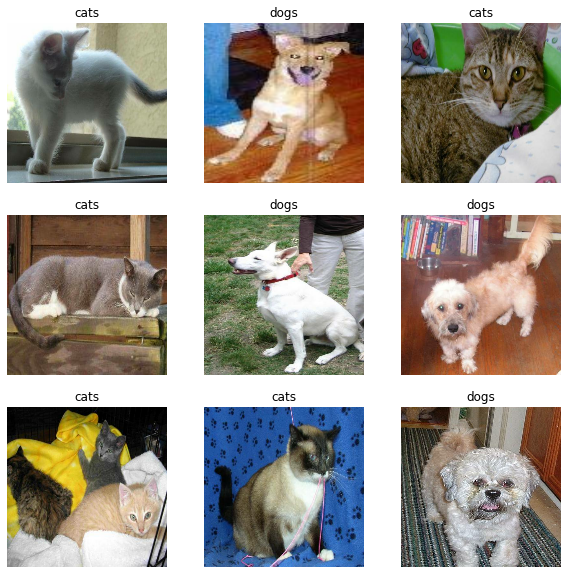

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

原始数据集中不包含测试集,你可以自己创建一个.为此,请使用`tf.data.experimental.cardinality`确定验证集中有多少批数据可用,然后将其中的20%移到测试集中.

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


## 配置数据集性能

为了避免I/O成为性能瓶颈,使用缓存预取从磁盘读取图片.

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## 数据增广

如果你的数据集不够大,通过对训练图像（如旋转和水平翻转）应用随机但真实的变换,可以人为地引入样本多样性。这可以帮助模型提高鲁棒性和降低过拟合.

In [8]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
    ]
)

> Note: 这些层只会在你调用`model.fit`的时候会激活,在你推理的过程中,这些是不会被激活的

查看数据增广的结果

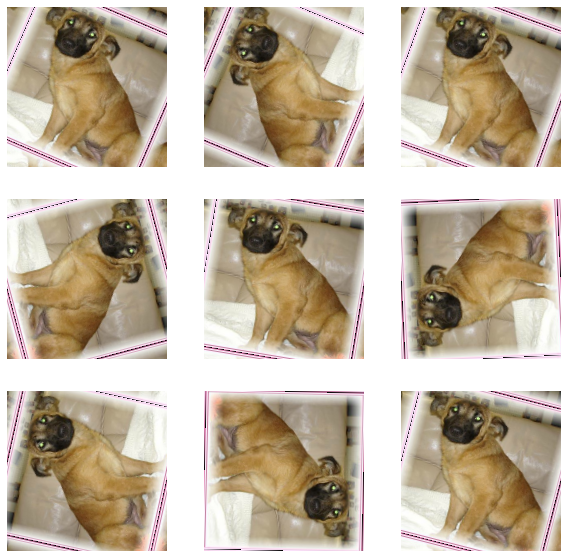

In [9]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## 像素值缩放

同时,你可以下载`tf.keras.applications.MobileNetV2`作为你的骨干网络,这个模型预期的输入是`[-1, 1]`,但是现在的图像数据范围是`[0-255]`,使用包含在模型中的`preprocessing `方法去缩放.

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

>  当然,你也可以使用Rescaling层将像素值从`[0, 255]`归一化到`[-1, 1]`

In [11]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

> 如果使用其他的`tf.keras.applications`,检查API文档确定模型期待的像素值范围是`[-1, 1]`或`[0, 1]`,或者使用`preprocess_input`方法

## 从预训练的卷积网络中构建基础模型

你可以使用谷歌开发的`MobileNet V2 `模型来构建你的基础模型.该模型使用ImageNet数据集进行预训练,该数据集包含1000类1.4M张图像.

首先,你需要选择使用MobileNet V2的哪些层提取特征.最后的分类层(顶层,因为大多数机器学习模型的图表是从下到上的)是没有用的.你需要用到的是flatten操作之前的层,这些层叫做"bottleneck layer". 与最终/顶层相比，瓶颈层特征保留了更多的通用性。

实例化带有预训练权重(ImageNet)MobileNet V2模型,通过指定`include_top=False`参数,你会加载一个不包含分类层的网络,这就是特征提取的理想网络.


In [12]:
IMG_SHAPE = IMG_SIZE + (3, )
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

此特征提取程序将每个160x160x3图像转换为5x5x1280特征块.

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 1280])

## 特征提取

在这一步中,您将冻结上一步创建的卷积网络,并将其用作特征提取程序.另外,在它上面添加一个分类器,并训练顶级分类器。

### 冻结基础卷积层

在你编译和训练模型之前冻结卷积层操作是很重要的.冻结(通过设置 layer.trainable=False)防止在训练期间更新指定层中的权重. MobileNet V2有许多层,所以使用模型的`trainable`变量为False去冻结它们

In [14]:
base_model.trainable = False

## 关于BatchNormalization的重要说明

许多模型包含`tf.keras.layers.BatchNormalization`层.这一层是一种特殊情况,在进行微调时应采取预防措施,如本教程后面部分所示.

当你设置`layer.trainable=False`时,BN层将在推理模式下运行，并且不会更新其均值和方差统计信息.

当你解冻包含BN层的模型进行微调时,你应当使用`training=False`保证BN层处于推理模式.否则,应用于不可训练权重的更新将破坏模型所学的内容.

In [15]:
base_model.summary()

xpand_relu[0][0]        
__________________________________________________________________________________________________
block_6_depthwise (DepthwiseCon (None, 10, 10, 192)  1728        block_6_pad[0][0]                
__________________________________________________________________________________________________
block_6_depthwise_BN (BatchNorm (None, 10, 10, 192)  768         block_6_depthwise[0][0]          
__________________________________________________________________________________________________
block_6_depthwise_relu (ReLU)   (None, 10, 10, 192)  0           block_6_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_6_project (Conv2D)        (None, 10, 10, 64)   12288       block_6_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_6_project_BN (BatchNormal (None, 10, 10, 64)   256         block_6_project[0][

## 添加分类层

要从特征中生成预测，请使用`tf.keras.layer.GlobalAveragePooling2D`层将功能转换为每个图像的单个1280元素向量。

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


使用`tf.keras.layers.Dense`层将特征转换为单个预测结果,这里你不需要激活函数因为预测将被视为二分类,或者和一个原始的预测数值.正确的分类被预测为1,错误的分类被预测为0

In [17]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


通过使用Keras函数API将数据扩充、重缩放、基本模型和特征提取层链接在一起，构建模型。如前所述，使用training=False，因为我们的模型包含一个BN层。

In [18]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

## 模型编译

在训练模型之前编译模型,此处任务为二分类,所以使用二分类loss

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

2.5M原始模型的参数被冻结,但是全连接层还有1.2k的可训练参数.这些被分成两部分`tf.Variable`对象，权重和偏差。

In [21]:
len(model.trainable_variables)

2

## 训练模型

在10次迭代之后,你可以的到一个在验证集中94%准确率的模型

In [22]:
init_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 1s 30ms/step - loss: 0.8043 - accuracy: 0.4901


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.80
initial accuracy: 0.49


In [24]:
history = model.fit(train_dataset,
                    epochs=init_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 3s 52ms/step - loss: 0.6925 - accuracy: 0.5925 - val_loss: 0.5731 - val_accuracy: 0.7203
Epoch 2/10
63/63 [==============================] - 3s 50ms/step - loss: 0.5474 - accuracy: 0.7020 - val_loss: 0.4129 - val_accuracy: 0.8329
Epoch 3/10
63/63 [==============================] - 3s 50ms/step - loss: 0.4528 - accuracy: 0.7745 - val_loss: 0.3338 - val_accuracy: 0.8861
Epoch 4/10
63/63 [==============================] - 3s 50ms/step - loss: 0.3905 - accuracy: 0.8120 - val_loss: 0.2786 - val_accuracy: 0.9047
Epoch 5/10
63/63 [==============================] - 3s 50ms/step - loss: 0.3550 - accuracy: 0.8325 - val_loss: 0.2318 - val_accuracy: 0.9196
Epoch 6/10
63/63 [==============================] - 3s 50ms/step - loss: 0.3056 - accuracy: 0.8675 - val_loss: 0.2044 - val_accuracy: 0.9468
Epoch 7/10
63/63 [==============================] - 3s 49ms/step - loss: 0.2975 - accuracy: 0.8610 - val_loss: 0.1824 - val_accuracy: 0.9468
Epoch 8/10
63

## 学习曲线

让我们看看使用MobileNet V2基本模型作为固定特征提取器时的训练和验证准确性/损失的学习曲线。

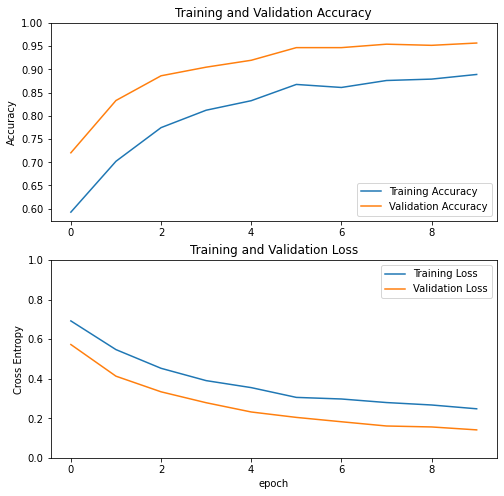

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

如果您想知道为什么验证指标明显优于训练指标,主要原因时因为类似`tf.keras.layers.BatchNormalization` 和 `tf.keras.layers.Dropout`在训练时影响了准确性,在验证阶段,它们时关闭的.

在较小程度上，这也是因为训练度量报告了一个epoch的平均值，而验证度量值是在epoch之后评估的，因此验证度量值看到的是训练时间稍长的模型。

## 微调

在特征提取实验中,你仅训练了Mobile Net V2的较少层,该模型的预训练权重在训练时并未更新.

进一步提高性能的一种方法是训练（或“微调”）预先训练模型顶层的权重,同时训练所添加的分类器。训练过程将迫使权重从一般特征映射调整到与数据集特定关联的特征。

>只有在将预训练模型设置为不可训练的情况下训练顶级分类器后,才应尝试执行此操作。如果在预先训练的模型上添加一个随机初始化的分类器,并尝试联合训练所有层，则梯度更新的幅度将太大（由于来自分类器的随机权重）,并且预先训练的模型将忘记它所学的内容。

此外,您应该尝试微调少量顶层,而不是整个MobileNet模型。在大多数卷积网络中,一个层次越高，它就越专业化。前几层学习非常简单和通用的特性,这些特性几乎适用于所有类型的图像。当你往上走的时候,这些特性越来越具体到训练模型的数据集。微调的目标是使这些专门的特性适应新的数据集,而不是覆盖一般的学习。


## 解冻模型顶层

你所需要做的就是解冻基础模型然后将底层设置为不可训练.然后重新编译模型并训练

In [26]:
base_model.trainable = True

In [29]:
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  155


## 编译模型

由于您正在训练一个大得多的模型,并且希望重新适应预训练权重,在这个阶段使用较低的学习率是很重要的。否则,您的模型可能会很快过拟合。

In [30]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [32]:
len(model.trainable_variables)

58

In [34]:
fine_tune_epochs = 10
total_epochs =  init_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 4s 60ms/step - loss: 0.1978 - accuracy: 0.9140 - val_loss: 0.0652 - val_accuracy: 0.9814
Epoch 11/20
63/63 [==============================] - 3s 50ms/step - loss: 0.1604 - accuracy: 0.9315 - val_loss: 0.1238 - val_accuracy: 0.9592
Epoch 12/20
63/63 [==============================] - 3s 51ms/step - loss: 0.1512 - accuracy: 0.9335 - val_loss: 0.0589 - val_accuracy: 0.9839
Epoch 13/20
63/63 [==============================] - 3s 51ms/step - loss: 0.1349 - accuracy: 0.9465 - val_loss: 0.0404 - val_accuracy: 0.9851
Epoch 14/20
63/63 [==============================] - 3s 50ms/step - loss: 0.1279 - accuracy: 0.9460 - val_loss: 0.0428 - val_accuracy: 0.9851
Epoch 15/20
63/63 [==============================] - 3s 50ms/step - loss: 0.1282 - accuracy: 0.9485 - val_loss: 0.0432 - val_accuracy: 0.9827
Epoch 16/20
63/63 [==============================] - 3s 49ms/step - loss: 0.1013 - accuracy: 0.9610 - val_loss: 0.0416 - val_accuracy: 0.9864
Epoch 

让我们看看在微调MobileNet V2基本模型的最后几层并在其上训练分类器时，训练和验证精度/损失的学习曲线。验证损失远高于培训损失，因此您可能会得到一些过度拟合。
由于新的训练集相对较小，并且与原始的MobileNet V2数据集相似，您也可能会得到一些过度拟合。
经过微调后，模型在验证集上的准确率接近98%。

In [35]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

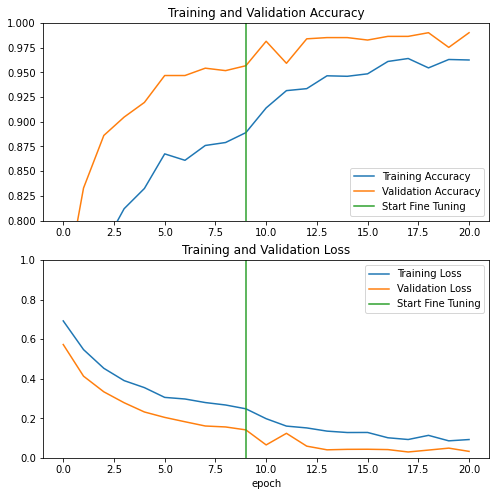

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([init_epochs-1,init_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([init_epochs-1,init_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 评估和预测

最后你可以使用测试集在新数据上评估模型性能

In [38]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 0s 27ms/step - loss: 0.0390 - accuracy: 0.9792
Test accuracy : 0.9791666865348816


Predictions:
 [0 1 0 0 1 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 0 1 0 0 0 0 1 1]
Labels:
 [0 1 0 0 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 1 0 0 1 0 0 0 0 1 1]


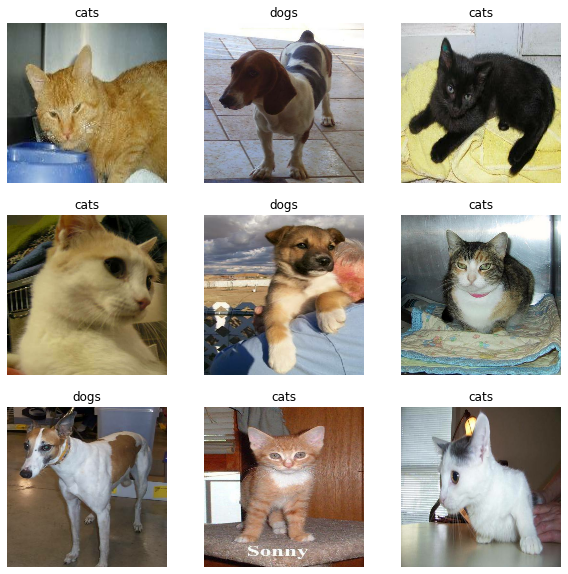

In [39]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## 总结

使用预先训练的模型进行特征提取：在处理小数据集时，通常的做法是利用在同一领域中较大的数据集上训练的模型所学习的特性。这是通过实例化预先训练的模型并在顶部添加一个完全连接的分类器来完成的。预先训练的模型是“冻结”的，在训练过程中只有分类器的权重得到更新。在本例中，卷积基提取了与每个图像相关联的所有特征，而您只需训练一个分类器，该分类器根据所提取的特征集确定图像类别。
微调预先训练的模型：为了进一步提高性能，可以通过微调将预先训练模型的顶层重新调整为新的数据集。在本例中，您调整了权重，使您的模型了解特定于数据集的高级特性。当训练数据集很大并且与预先训练的模型所使用的原始数据集非常相似时，通常推荐使用这种技术。